In [51]:
import os
#import fitsio
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import goodness_of_fit
from scipy.stats import chisquare
from scipy.stats import binned_statistic_2d
import statsmodels.api as sm
from scipy.optimize import minimize

In [2]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Question 1: `git` in Practice

[Link to my repository](https://github.com/Pripriiiii/ASTR4004.git)

# Question 2: Using ADQL to Search for Bright Stars Around the Open Cluster M67

### (1): Download all stars within 1 degree of the center of Messier 67 that are brighter than G = 14 in Gaia DR3 (the table is called gaiadr.gaia source) and include a crossmatch these stars with the 2MASS catalog and report your ADQL query text (use the """query""" notation)

In [3]:
# Define the position of Messier 67, search radius and the Gaia G magnitude threshold
ra_M67 = 132.825*(u.deg)
dec_M67 = 11.8*(u.deg)
r_search = 1*(u.deg)
G_thresh = 14

# Query Gaia DR3 for sources within the search radius of M67 and brighter than G_thresh
query = f"""
SELECT *
FROM gaiadr3.gaia_source 
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON
   xjoin.original_psc_source_id = tmass.designation
WHERE 
CONTAINS(
	POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
	CIRCLE('ICRS',132.825,11.8,1)
)=1  AND  (gaiadr3.gaia_source.phot_g_mean_mag<=14)
"""

# Upload the source_id table for crossmatching
job = Gaia.launch_job_async(query=query)
gaiadr3_match = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


### (2): Determine how many stars are returned from the initial query.

In [4]:
# Check the number of rows returned
num_stars = len(gaiadr3_match)
print(f"Number of stars returned from the initial query: {num_stars}")

Number of stars returned from the initial query: 1018


### (3): Identify any stars with bad 2MASS photometry, where ph_qual is not ’AAA’.

In [5]:
# Modify the initial query by filtering out sources with bad photometry
query2 = f"""
SELECT *
FROM gaiadr3.gaia_source 
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON
   xjoin.original_psc_source_id = tmass.designation
WHERE 
CONTAINS(
	POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
	CIRCLE('ICRS',132.825,11.8,1)
)=1  AND  (gaiadr3.gaia_source.phot_g_mean_mag<=14) AND 
tmass.ph_qual ='AAA'
"""

# Upload the source_id table for crossmatching
job2 = Gaia.launch_job_async(query=query2)
gaiadr3_match2 = job2.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
# Check the number of stars with bad photometry(initial-filtered)
num_goodphot = len(gaiadr3_match2)
num_badphot = num_stars - num_goodphot
print(f"Number of stars with bad 2MASS photometry: {num_badphot}")

Number of stars with bad 2MASS photometry: 21


### (4): Identify any stars with negative (or non-positive) parallaxes in the Gaia data.

In [7]:
num_negparallax = len(gaiadr3_match[gaiadr3_match['parallax']<0])
print(f"Number of stars with negative parallaxes in the Gaia data: {num_negparallax}")

Number of stars with negative parallaxes in the Gaia data: 2


### (5): Apply these two quality cuts (removing stars with bad 2MASS photometry and nonpositive parallaxes). After applying the cuts, determine how many stars remain.

In [8]:
# Modify the initial query by filtering out sources with bad photometry and negative parallaxes
query3 = f"""
SELECT *
FROM gaiadr3.gaia_source 
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON
   xjoin.original_psc_source_id = tmass.designation
WHERE 
CONTAINS(
	POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
	CIRCLE('ICRS',132.825,11.8,1)
)=1  AND  (gaiadr3.gaia_source.phot_g_mean_mag<=14) AND 
tmass.ph_qual ='AAA' AND
gaiadr3.gaia_source.parallax>0
"""

# Upload the source_id table for crossmatching
job3 = Gaia.launch_job_async(query=query3)
gaiadr3_match3 = job3.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
# Check the how many stars remain
num_stars_remain = len(gaiadr3_match3)
print(f"Number of stars remaining after filtering: {num_stars_remain}")

Number of stars remaining after filtering: 988


### (6): Using the remaining stars, generate a figure with two panels
(a) A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.

(b) A 2MASS J-Ks vs. apparent K magnitude diagram.


In [10]:
# First calculate the absolute G magnitude of Gaia data
BP_RP = gaiadr3_match3['bp_rp'] # Gaia BP-RP
g_apparent = gaiadr3_match3['phot_g_mean_mag']
g_absolute = g_apparent - 5*np.log10(100/gaiadr3_match3['parallax'])
finite = np.isfinite(gaiadr3_match3['bp_rp']) & np.isfinite(gaiadr3_match3['phot_bp_mean_mag'])

# A 2MASS J-Ks vs. apparent K magnitude diagram.
tmass_J_Ks = gaiadr3_match3['j_m'] - gaiadr3_match3['ks_m']
finite2 = np.isfinite(gaiadr3_match3['j_m']) & np.isfinite(gaiadr3_match3['ks_m'])

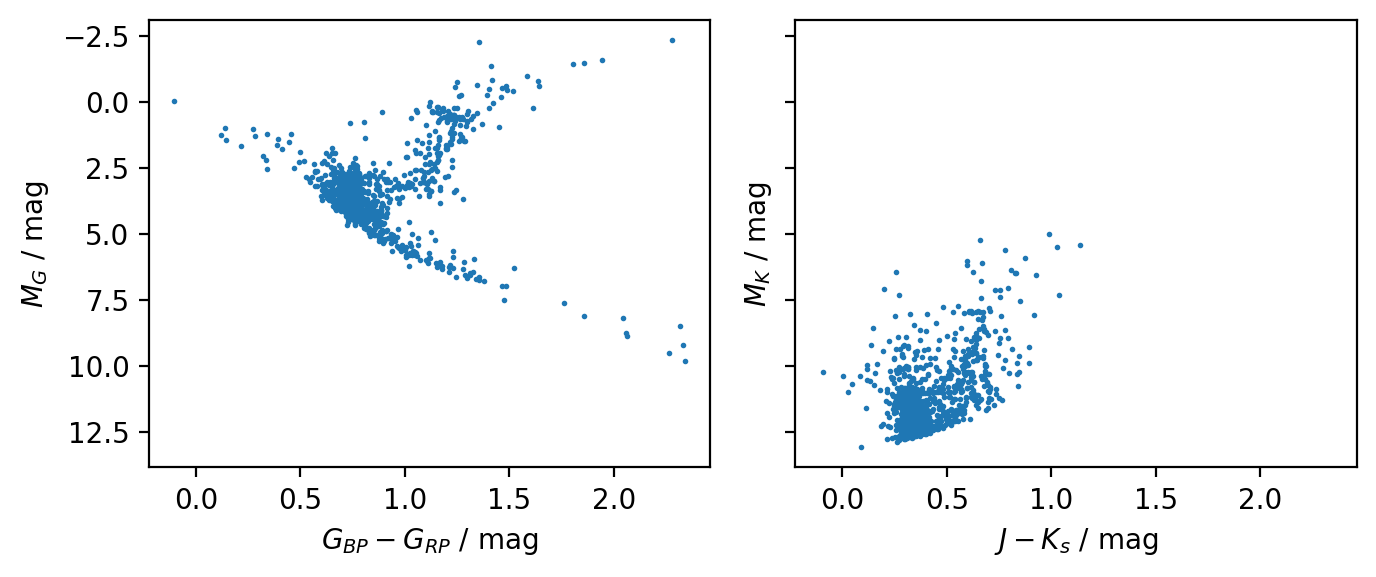

In [11]:
# To create a plot with 2 panels, use the plt.subplots routine
f, gs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(7,3))

# Plot a scatter plot in the first panel
ax=gs[0]
ax.scatter(BP_RP[finite],g_absolute[finite],s=1);
ax.set_xlabel(r'$G_{BP} - G_{RP}$ / mag')
ax.set_ylabel(r'$M_G$ / mag')

# Plot a 2-dimensional histogram in the second panel
ax=gs[1]
ax.scatter(tmass_J_Ks[finite2],gaiadr3_match3['ks_m'][finite2],s=1);
ax.set_xlabel(r'$J - K_{s}$ / mag')
ax.set_ylabel(r'$M_K$ / mag')

# Invert the y-axis
ax.invert_yaxis()

plt.tight_layout()
plt.show()
plt.close()

### (7): Save the figure as `figures/cmds M67.png` with a resolution of 200 dots per inch.

In [13]:
# Save the figure as figures/cmds M67.png with a resolution of 200 dots per inch.
f.savefig('cmds_M67.png',dpi=200)

### (8): Give your colleague a recommendation for the potential proposal when only judging the fibre usage.

Give your colleague a recommendation for the potential proposal when only judging the fibre usage:

1. Th plots indicate a substantial number of stars, meaning that will have enough stars to efficiently fill the fibres of the 2dF fibre positioner.

2. The stars are not overly clustered, which suggests that fibre placement should not be problematic. There appears to be enough coverage across the field to utilize the fibres efficiently.

# Question 3: The radial metallicity relation in simulated data

### (1): Plot a 2-panel figure:
(a) Logarithmic density plot of $R_{\text{Gal.}}$ vs. $\mathrm{A(O)}$, with a linear fit and legend.

(b) Residuals of the fit, $R_{\text{Gal.}}$ vs. $\Delta \mathrm{A(O)}$.

In [44]:
# Open the fits file and read the data and header
fits_file = fits.open('nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')
fits_data = fits_file[1].data
fits_header = fits_file[0].header
fits_file.close()

# Extract the x, y, and z positions and A(O)
x = fits_data['x']
y = fits_data['y']
z = fits_data['z']
A_O = fits_data['A_O']
R_Gal = np.sqrt(x**2 + y**2)

# Perform linear regression using linregress
slope, intercept, r_value, p_value, std_err = linregress(R_Gal, A_O)

# Compute predicted values and residuals
A_O_fit = intercept + slope * R_Gal
residuals = A_O - A_O_fit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


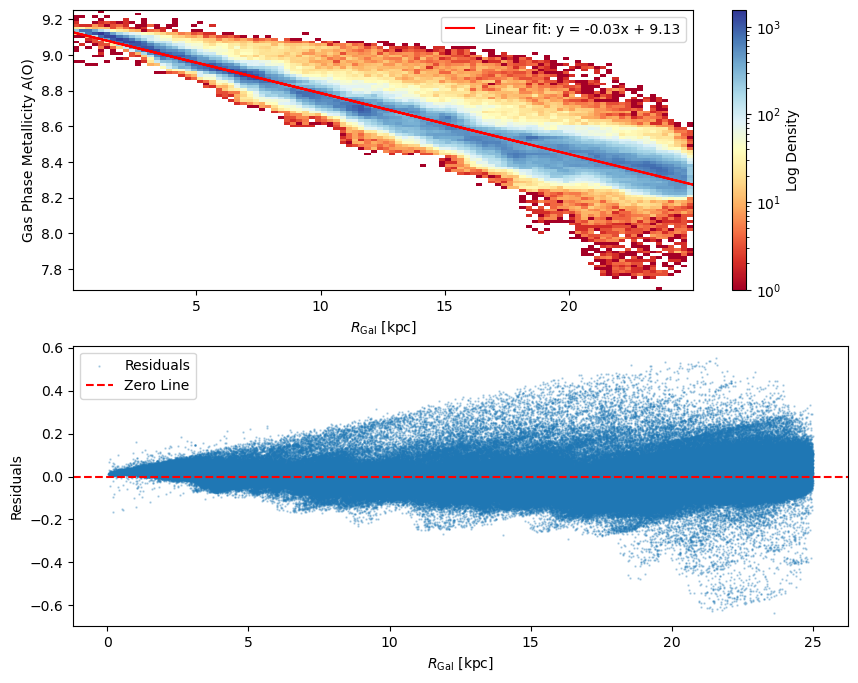

In [42]:
# Plot logarithmic density plot
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)  # Create the first subplot

# Use a 2D histogram for density plot
plt.hist2d(R_Gal, A_O, bins=100,norm=mpl.colors.LogNorm(), cmap = 'RdYlBu')
plt.colorbar(label='Log Density')

# Add linear regression fit
slope, intercept, r_value, p_value, std_err = linregress(R_Gal, A_O)
plt.plot(R_Gal, slope * R_Gal + intercept, color='red', label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}')
plt.legend()

plt.xlabel(r'$R_{\text{Gal}}$ [kpc]')
plt.ylabel('Gas Phase Metallicity A(O)')
#plt.title('Logarithmic Density Plot: $R_{\text{Gal}}$ vs. A(O)')

plt.subplot(2, 1, 2)  # Create the second subplot
plt.scatter(R_Gal, residuals,alpha=0.3,s=0.5, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel(r'$R_{\text{Gal}}$ [kpc]')
plt.ylabel('Residuals')
#plt.set_title('Residuals of the Fit, R_gal vs. A(O)')
plt.legend()

### (2): Use a python fitting tool to fit a linear function to the data, reporting the intercept and slope with uncertainties. Include any hyperparameters used.

In [43]:
# Define the linear function
def linear_model(x, m, c):
    return m * x + c

# Fit the model using curve_fit
popt, pcov = curve_fit(linear_model, R_Gal, A_O)

# popt contains the best-fit values for the slope and intercept
slope, intercept = popt

# pcov contains the covariance matrix, which gives us the uncertainties
slope_uncertainty, intercept_uncertainty = np.sqrt(np.diag(pcov))

# Print the results
print(f"Slope: {slope:.4f} ± {slope_uncertainty:.4f}")
print(f"Intercept: {intercept:.4f} ± {intercept_uncertainty:.4f}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Slope: -0.0342 ± 0.0000
Intercept: 9.1278 ± 0.0002


### (3): Discuss where the linear model fits well and where it does not. Use statistical metrics, such as the root mean squares or other goodness-of-fit indicators, to quantify the performance of your linear fit in general and regions with larger residuals.

In [7]:
## General statistics
# Calculate RSS, RMSE, R² and Chi²
RSS = np.sum(residuals**2)
RMSE = np.sqrt(np.mean(residuals**2)) # Root Mean Squared Error
R2 = r_value**2
Chi2 = np.sum((residuals ** 2) / A_O_fit)
Chi2_reduced = Chi2 / (len(A_O) - 2)
# AIC and BIC
n = len(A_O)
k = 2 
AIC = n * np.log(RSS/n) + 2 * k
BIC = n * np.log(RSS/n) + k * np.log(n)


# Print the results
print(f"RSS: {RSS:.4f}")
print(f"RMSE: {RMSE:.4f}")
print(f"R²: {R2:.4f}")
print(f"Chi²: {Chi2:.4f}")
print(f"Reduced Chi²: {Chi2_reduced:.4f}")
print(f"AIC: {AIC:.4f}")
print(f"BIC: {BIC:.4f}")

RSS: 5732.9290
RMSE: 0.1059
R²: 0.8143
Chi²: 653.9666
Reduced Chi²: 0.0013
AIC: -2297314.2241
BIC: -2297291.9338


In [46]:
# Quantify the performance of the linear fit in general
# since it is best for Regression analysis with robust statistical output, linear and polynomial regression.
x_with_intercept = sm.add_constant(R_Gal)  # Adds the intercept term
linear_model = sm.OLS(A_O, x_with_intercept).fit()
# Print linear model summary (with statistical info)
print(linear_model.summary())


# Root Mean Squared Error
RMSE = np.sqrt(np.mean(residuals**2)) # Root Mean Squared Error
print(f"RMSE: {RMSE:.4f}")

# Chi-squared and reduced Chi-squared
Chi2 = np.sum((residuals ** 2) / A_O_fit)
Chi2_reduced = Chi2 / (len(A_O) - 2)
#print(f"Chi²: {Chi2:.4f}, Reduced Chi²: {Chi2_reduced:.4f}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 5.337e+06
Date:                Fri, 04 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:04:19   Log-Likelihood:             6.1547e+05
No. Observations:              511520   AIC:                        -1.231e+06
Df Residuals:                  511518   BIC:                        -1.231e+06
Df Model:                           1                                         
Covariance Type:            nonrobust  

By quantifing the performance of the linear fit in general using results from statsmodels.api as sm, since it is best for Regression analysis with robust statistical output, linear and polynomial regression, we obtained the above results. 

The R-squared value is 0.913 meaning the linear model explains 91.3% of the variance in the dependent variable gas phase metallicity. This indicates a strong fit in general. The Root Mean Square Error (RMSE) is 0.0726, which measures the average deviation between the observed data and the predicted values, this indicates that the residual errors are relatively small, showing the model's overall accuracy. Additionally, the Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. Here, the very smalle value of AIC (-1.2e6) indicates that the linear model is a relatively better fit.


In [47]:
# Quantify the performance of the linear fit for the most inner region
# select the inner 5kpc 
R_inner = R_Gal[R_Gal < 5]
A_O_inner = A_O[R_Gal < 5]
A_O_fit_inner = A_O_fit[R_Gal < 5]
residuals_inner = A_O_inner - A_O_fit_inner
x_with_intercept_inner = sm.add_constant(R_inner)  # Adds the intercept term
linear_model_inner = sm.OLS(A_O_inner, x_with_intercept_inner).fit()
# Print linear model summary (with statistical info)
print(linear_model_inner.summary())


# Root Mean Squared Error
RMSE_inner = np.sqrt(np.mean(residuals_inner**2)) # Root Mean Squared Error
print(f"RMSE: {RMSE_inner:.4f}")

# Chi-squared and reduced Chi-squared
# Chi2 = np.sum((residuals ** 2) / A_O_fit)
# Chi2_reduced = Chi2 / (len(A_O) - 2)
#print(f"Chi²: {Chi2:.4f}, Reduced Chi²: {Chi2_reduced:.4f}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                 2.280e+05
Date:                Fri, 04 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:05:09   Log-Likelihood:             1.4625e+05
No. Observations:               65587   AIC:                        -2.925e+05
Df Residuals:                   65585   BIC:                        -2.925e+05
Df Model:                           1                                         
Covariance Type:            nonrobust  

From the residual plot, we can see that the linear model doesfit well at the very inner region of the galaxy. 

Here, we use the same method to quantify the the performance of the linear fit in the very inner region of the galaxy (R<5kpc). This time, though the R-squared value decreases to 0.777, the RMSE decrease to 0.0323, meaning that the linear model could fit better in the very inner region of the galaxy. The AIC value is -2.9e5, which is still very small, indicating that the linear model is still a relatively better fit.

In [49]:
# Quantify the performance of the linear fit for the regions with larger residuals.
# select the inner 5kpc 
R_large_res = R_Gal[R_Gal>10]
A_O_large_res = A_O[R_Gal>10]
A_O_fit_large_res = A_O_fit[R_Gal>10]
residuals_large_res = A_O_large_res - A_O_fit_large_res
x_with_intercept_large_res = sm.add_constant(R_large_res)  # Adds the intercept term
linear_model_large_res = sm.OLS(A_O_large_res, x_with_intercept_large_res).fit()
# Print linear model summary (with statistical info)
print(linear_model_large_res.summary())


# Root Mean Squared Error
RMSE_large_res = np.sqrt(np.mean(residuals_large_res**2)) # Root Mean Squared Error
print(f"RMSE: {RMSE_large_res:.4f}")

# Chi-squared and reduced Chi-squared
# Chi2 = np.sum((residuals ** 2) / A_O_fit)
# Chi2_reduced = Chi2 / (len(A_O) - 2)
#print(f"Chi²: {Chi2:.4f}, Reduced Chi²: {Chi2_reduced:.4f}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                 9.225e+05
Date:                Fri, 04 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:13:37   Log-Likelihood:             3.8138e+05
No. Observations:              351687   AIC:                        -7.628e+05
Df Residuals:                  351685   BIC:                        -7.627e+05
Df Model:                           1                                         
Covariance Type:            nonrobust  

Here, we repeat the same analysis for the outer region of the galaxy (R>5kpc) with the larger residuals. The R-squared value keeps decreasing to 0.724. And, the RMSE values increase to 0.0828 which is the highes value among three trials. This suggests that the linear model fits the outer region of the galaxy less well, which is evident by the large rsiduals in the residual plot.

Overall, the linear model fits well in the inner region and in general, where the data closely follows the linear trend. The model explains a high percentage of the variance here, making it a strong fit. In the outer region, the large scatters likely cause deviations from the linear trend.

### (4): Plot a 3-panel figure for the x vs. y plane using the same bins and sensible colormaps:
(a) 2D-histogram of the median simulated A(O).

(b) 2D-histogram of the median fitted A(O)

(c) 2D-histogram of the median residuals ΔA(O).

In [ ]:
# Plot logarithmic density plot
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)  # Create the first subplot

# Use a 2D histogram for density plot
plt.hist2d(R_Gal, A_O, bins=100,norm=mpl.colors.LogNorm(), cmap = 'RdYlBu')
plt.colorbar(label='Log Density')

# Add linear regression fit
slope, intercept, r_value, p_value, std_err = linregress(R_Gal, A_O)
plt.plot(R_Gal, slope * R_Gal + intercept, color='red', label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}')
plt.legend()

plt.xlabel(r'$R_{\text{Gal}}$ [kpc]')
plt.ylabel('Gas Phase Metallicity A(O)')
#plt.title('Logarithmic Density Plot: $R_{\text{Gal}}$ vs. A(O)')

plt.subplot(2, 1, 2)  # Create the second subplot
plt.scatter(R_Gal, residuals,alpha=0.3,s=0.5, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel(r'$R_{\text{Gal}}$ [kpc]')
plt.ylabel('Residuals')
#plt.set_title('Residuals of the Fit, R_gal vs. A(O)')
plt.legend()

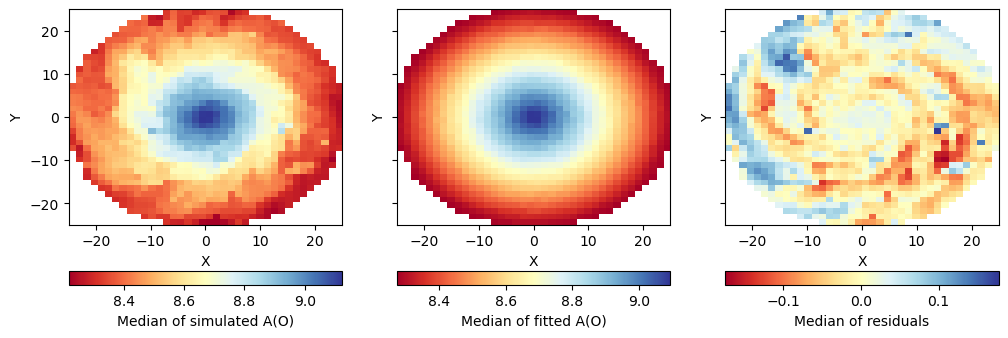

In [94]:
# Bins = 38
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

bin_num = 38
# First panel: 2D histogram (binned stats) colored by median simulated A(O)
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A_O,statistic='median', bins=bin_num)
im = axs[0].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[0].set_title("Binned Median of simulated A(O)")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
plt.colorbar(im, ax=axs[0], label="Median of simulated A(O)", orientation='horizontal')

# Second panel: 2D histogram (binned stats) colored by median fitted A(O)
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A_O_fit ,statistic='median', bins=bin_num)
im = axs[1].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[1].set_title("Binned Mean of Z")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
plt.colorbar(im, ax=axs[1], label="Median of fitted A(O)", orientation='horizontal')

# Third panel: 2D histogram (binned stats) colored by median residuals
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, residuals ,statistic='median', bins=bin_num)
im = axs[2].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[1].set_title("Binned Mean of Z")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
plt.colorbar(im, ax=axs[2], label="Median of residuals", orientation='horizontal')

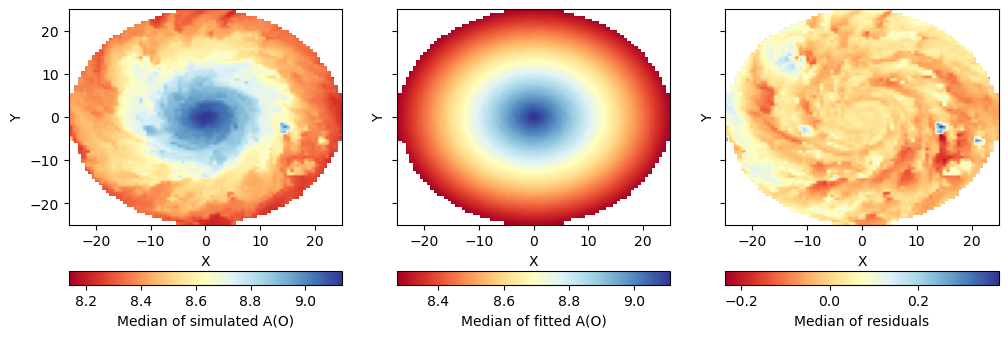

In [91]:
# Bins = 78
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

bin_num = 78
# First panel: 2D histogram (binned stats) colored by median simulated A(O)
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A_O,statistic='median', bins=bin_num)
im = axs[0].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[0].set_title("Binned Median of simulated A(O)")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
plt.colorbar(im, ax=axs[0], label="Median of simulated A(O)", orientation='horizontal')

# Second panel: 2D histogram (binned stats) colored by median fitted A(O)
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A_O_fit ,statistic='median', bins=bin_num)
im = axs[1].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[1].set_title("Binned Mean of Z")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
plt.colorbar(im, ax=axs[1], label="Median of fitted A(O)", orientation='horizontal')

# Third panel: 2D histogram (binned stats) colored by median residuals
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, residuals ,statistic='median', bins=bin_num)
im = axs[2].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[1].set_title("Binned Mean of Z")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
plt.colorbar(im, ax=axs[2], label="Median of residuals", orientation='horizontal')

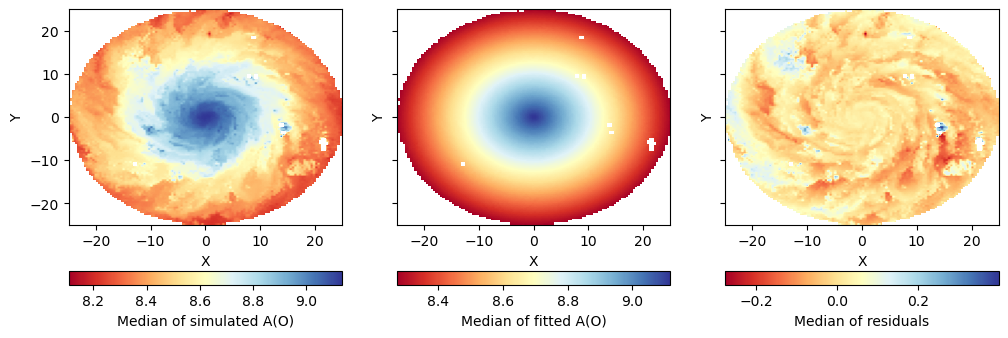

In [95]:
# Bins = 118
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

bin_num = 118
# First panel: 2D histogram (binned stats) colored by median simulated A(O)
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A_O,statistic='median', bins=bin_num)
im = axs[0].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[0].set_title("Binned Median of simulated A(O)")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
plt.colorbar(im, ax=axs[0], label="Median of simulated A(O)", orientation='horizontal')

# Second panel: 2D histogram (binned stats) colored by median fitted A(O)
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A_O_fit ,statistic='median', bins=bin_num)
im = axs[1].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[1].set_title("Binned Mean of Z")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
plt.colorbar(im, ax=axs[1], label="Median of fitted A(O)", orientation='horizontal')

# Third panel: 2D histogram (binned stats) colored by median residuals
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, residuals ,statistic='median', bins=bin_num)
im = axs[2].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
#axs[1].set_title("Binned Mean of Z")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
plt.colorbar(im, ax=axs[2], label="Median of residuals", orientation='horizontal')

### (5): Describe your choice of 2D bins. Discuss what details would be missed with fewer bins or problems encountered with more bins.

We used three choices of 2D bins: 38,78,118. 

$\textbf{When bins=38:}$

•	The bin size is relatively coarse, with larger individual bins.

•	In the simulated  A(O) plot, there is a general structure visible: a central region with lower metallicity and higher metallicity in the outer regions. However, finer details are largely smoothed out.
	
•	The fitted  A(O) plot looks relatively smooth because the model is linear and does not depend on bin size.

•	The residuals  $\Delta$ A(O) plot show some structure, but many details are lost due to the larger bin size. The spiral pattern is faint, and some complex structures are not well-resolved.

$\textbf{When bins=78:}$

•	The bin size is finer. The simulated  A(O) plot reveals more detail than before, showing more structure within the central region and clearer boundaries between different regions of metallicity. The sturcture of the spiral pattern is more visible.

•	The residuals plot show more pronounced structure. The spiral pattern becomes more evident as well, and the deviations of the fitted model from the simulated data are more visible.

$\textbf{When bins=118:}$

•	This is the finest binning option. In the simulated  A(O) plot, the inner region is highly resolved, showing significant local variations and structures in metallicity. The fitted  A(O) plot remains smooth, as expected, but the residuals  $\Delta$ A(O)  plot now show very detailed deviations.

$\textbf{Overall Details Missed with fewer bins:}$

•	With fewer bins, the coarse bin size smooths out local fluctuations, making it difficult to identify the detailed spatial distribution of metallicity and its variations.

•	The spiral structure seen in the residuals is largely lost. The smoothness hides potential regions where the model deviates from the observed values.

$\textbf{Problems Encountered with more bins:}$

•	With more bins, the individual bins become smaller, leading to noisy plots that may not accurately represent the underlying distribution. Small bin sizes may contain fewer data points, making the median estimates less reliable.

•	Some empty or nearly empty bins may appear, especially in regions with fewer data points. This can cause the median calculation to become unstable in those regions.

### (6): Analyze the residuals in more detail and propose an explanation for any patterns you observe.

Based on the above 3-pannel plot, we have the following key observations:

$\textbf{1. Spiral Patterns in the Residuals:}$

•	In all three choices of bins, the residuals show a clear spiral pattern that is not captured by the linear fit. With the increase of the number of bins, this spiral structure becomes more apparent. The spiral arms are regions where the residuals are significant, indicating that the linear model systematically underestimates or overestimates the metallicity in these areas. This may suggests that the simple linear fit is not capturing the complex dynamics associated with the spiral arms.

Explanation: The spiral arms of galaxies are regions of active star formation. As stars form, they enrich the interstellar medium with metals, which creates metallicity variations along the spiral arms. A linear model assumes a uniform metallicity gradient across the galaxy, so it cannot capture the localized enrichments caused by these processes, leading to systematic deviations in the residuals.

$\textbf{2. Positive and Negative Residuals:}$

•	There are regions where the residuals are positive (simulated  A(O)  > fitted  A(O) ) and regions where the residuals are negative (simulated  A(O)  < fitted  A(O) ).

Explanation: This alternating pattern of positive and negative residuals suggests that the linear model smooths out variations in metallicity that arise from localized processes. For example, the model may overestimate the metallicity in regions with gas inflows (where metals are being diluted) and underestimate it in regions of star formation (where metals are being enriched).

$\textbf{3. Residuals Near the outer region:}$

•	In the outer region of the galaxy, the residuals tend to be larger and more scattered compared to the inner region. This indicates that the linear model is less accurate and under-estimate in predicting metallicity in the outer regions.

Explanation: The outer regions of galaxies often have more complex dynamics, such as interactions with neighboring galaxies or gas accretion from the intergalactic medium. These processes can lead to non-linear variations in metallicity that are not captured by a simple linear model. The larger residuals suggest that the linear model is not flexible enough to account for these complexities, resulting in poorer fits in these regions.